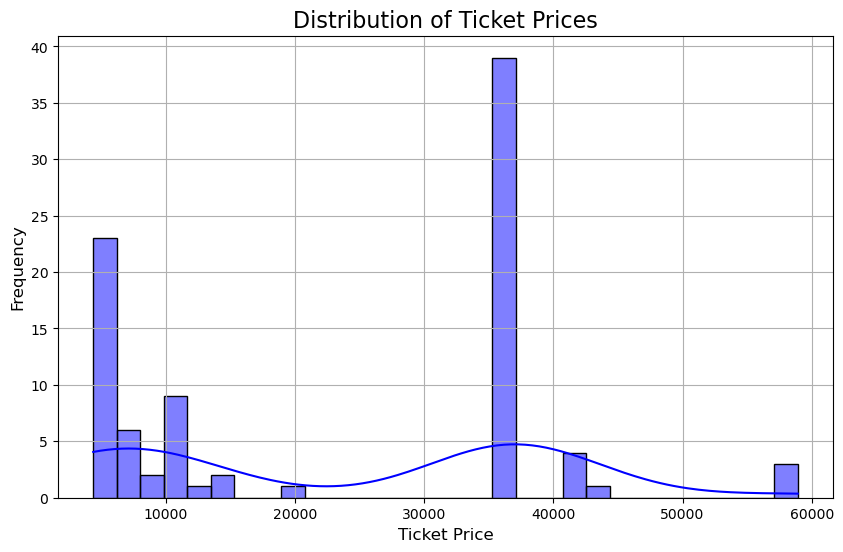

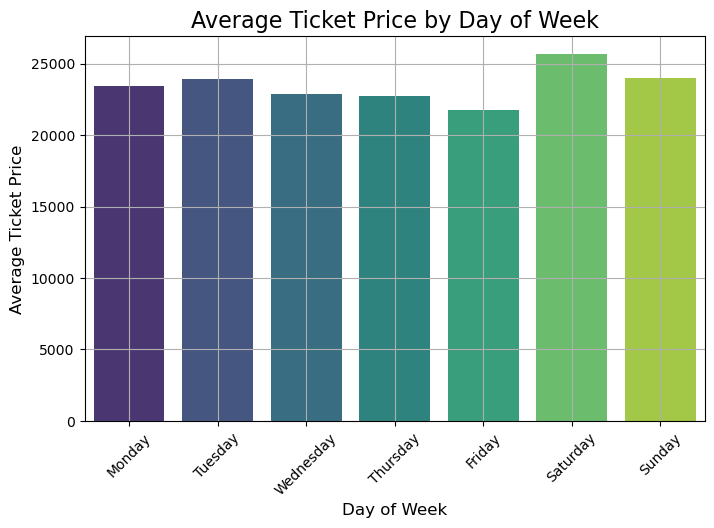

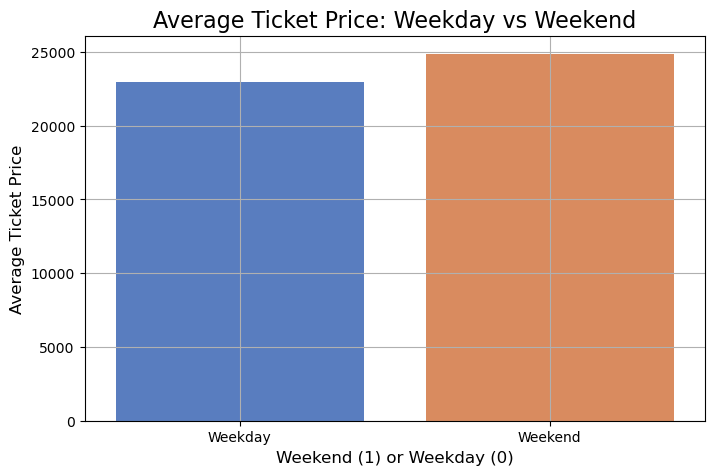

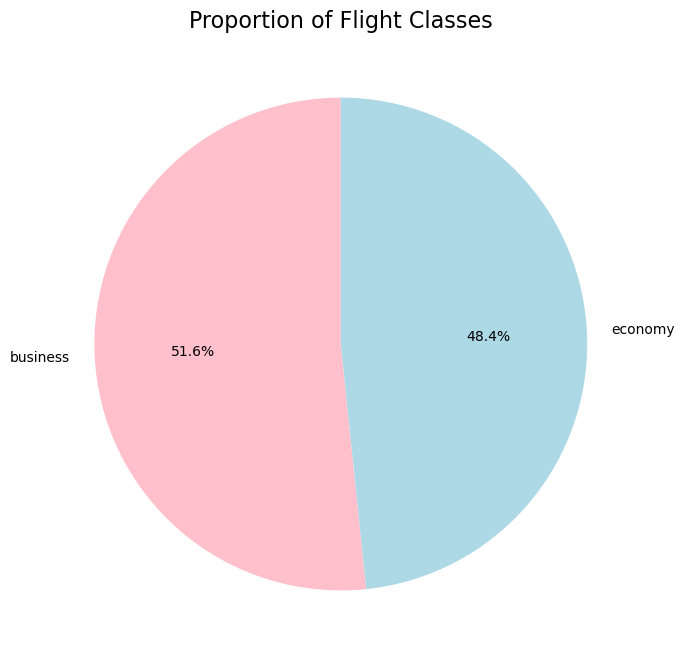

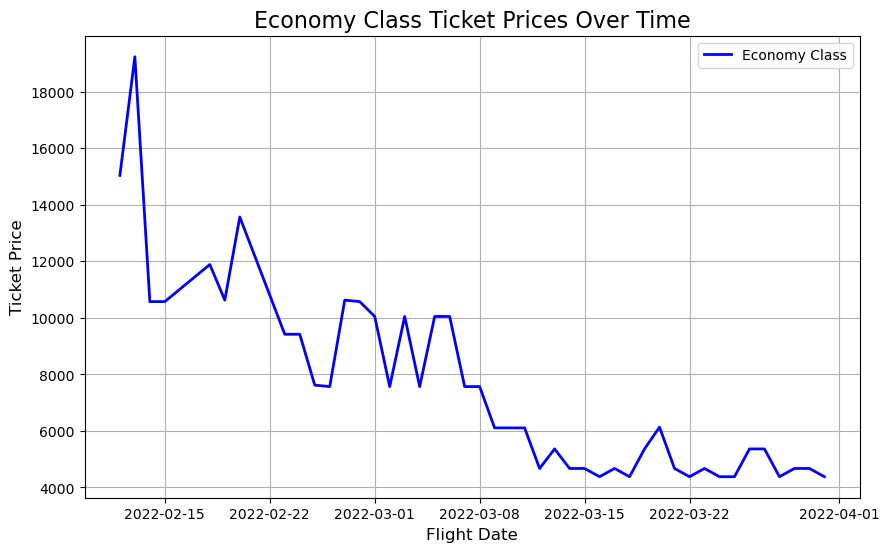

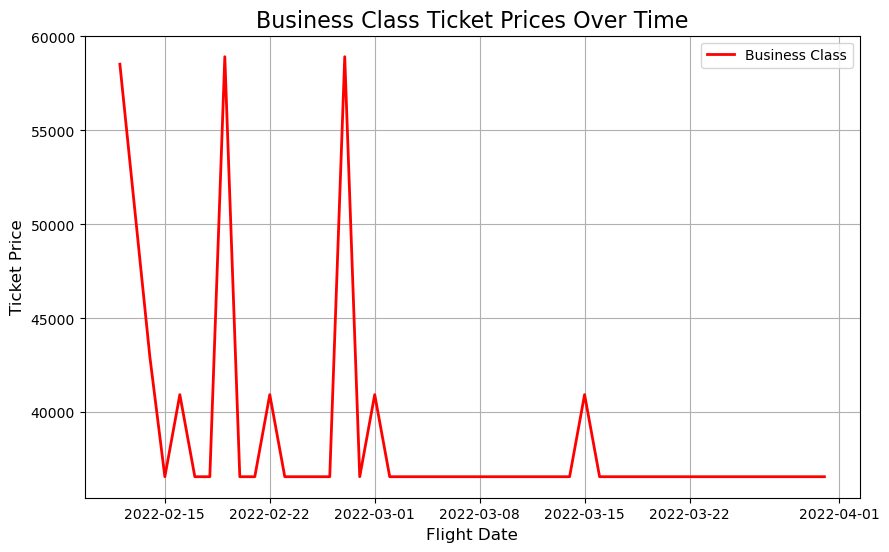

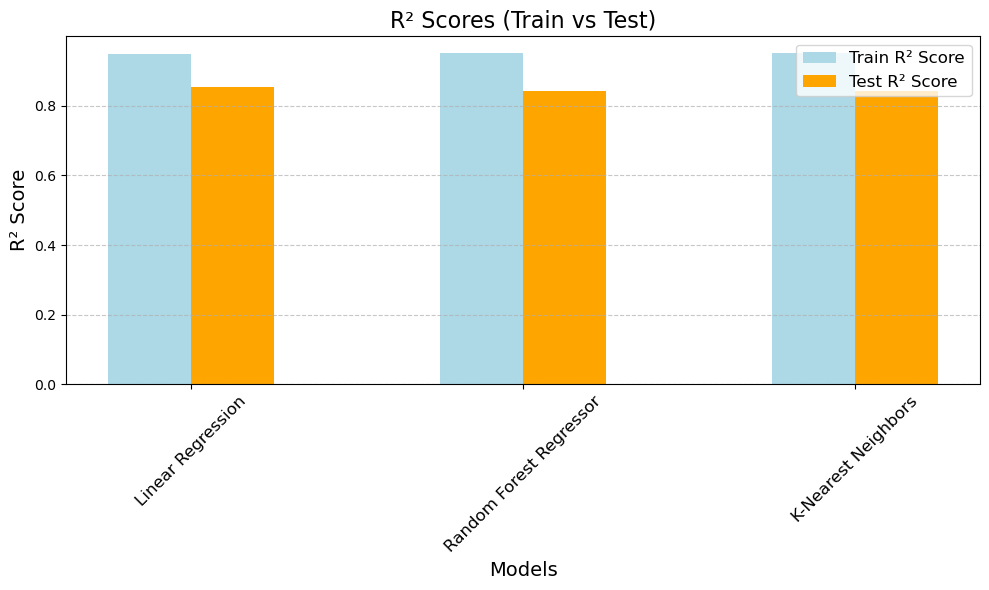

Best Parameters for Random Forest: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 100}
Best Parameters for KNN: {'n_neighbors': 7}


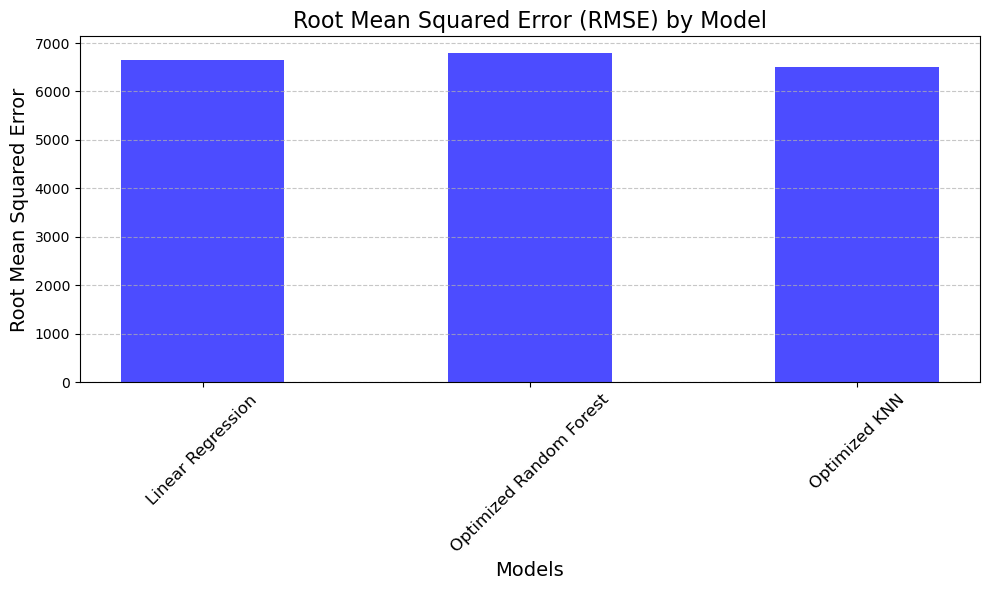

Model Performance Summary:
                     Model  Train R² Score  Test R² Score  Mean Squared Error
0        Linear Regression        0.947614       0.855056        4.415567e+07
1  Optimized Random Forest        0.949491       0.848297        4.621463e+07
2            Optimized KNN        0.948063       0.860705        4.243464e+07


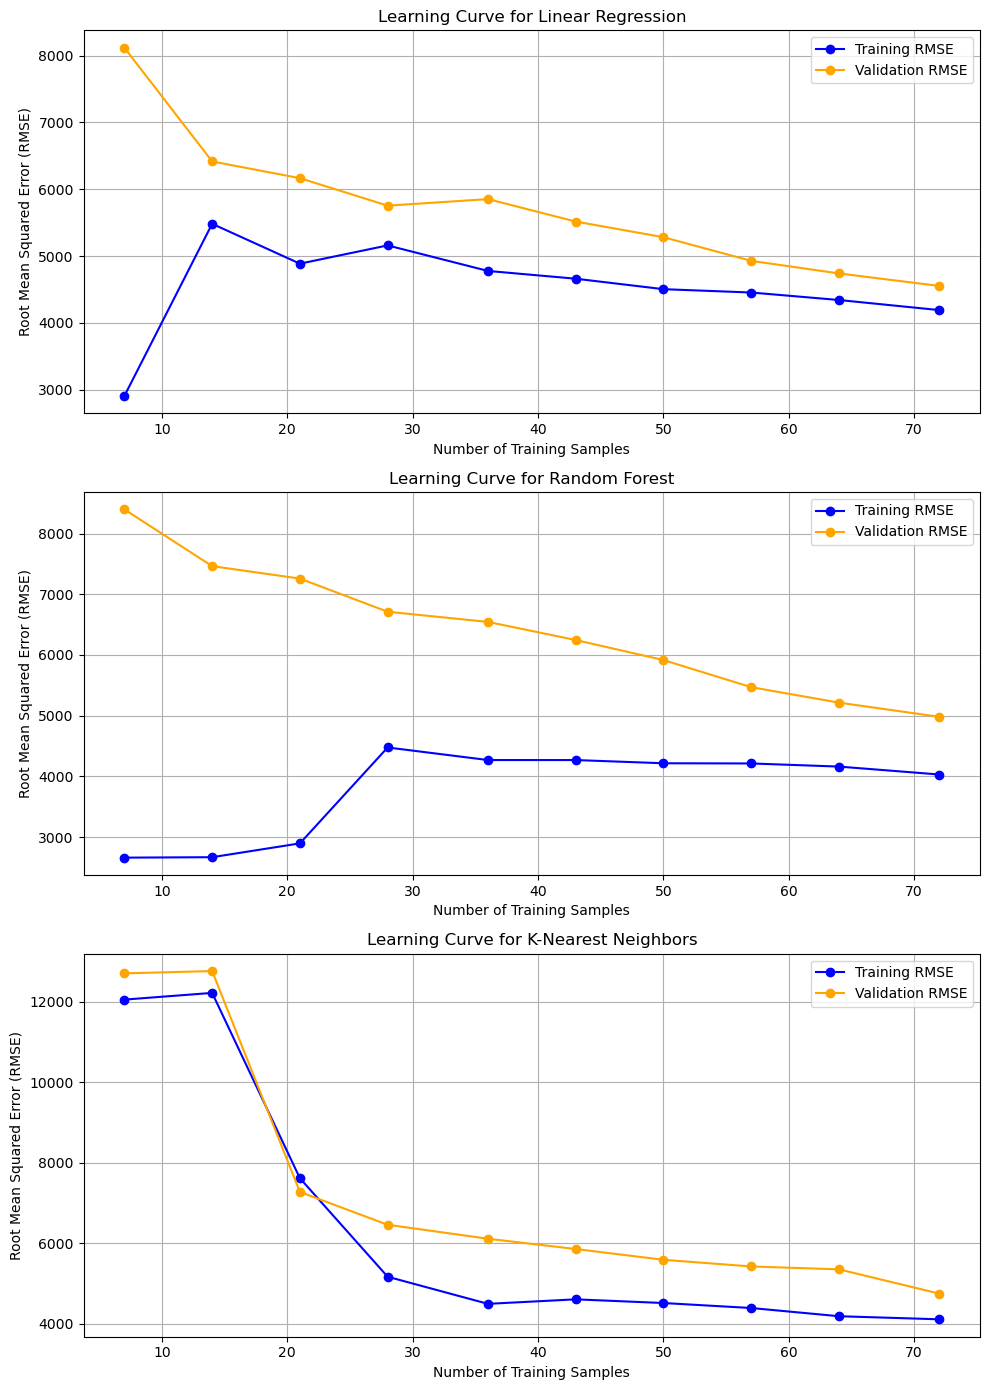

### RMSE Summary Table ###
                 Model  Training RMSE  Validation RMSE
0    Linear Regression    4191.153700      4552.717340
1        Random Forest    4030.535100      4980.166919
2  K-Nearest Neighbors    4105.986046      4745.612098


In [1]:
# ================== Importing Libraries ==================
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# ================== Data Loading and Preprocessing ==================

# Load and preprocess flight data
business = pd.read_csv('business.csv')
economy = pd.read_csv('economy.csv')

# Add a 'flight_class' column to distinguish between business and economy flights
business['flight_class'] = 'business'
economy['flight_class'] = 'economy'

# Combine the datasets into a single DataFrame
data = pd.concat([business, economy], ignore_index=True)

# Remove duplicates and missing values for clean data
data.drop_duplicates(inplace=True)
data.dropna(inplace=True)

# Rename columns for better clarity
data.rename(columns={
    'date': 'flight_date',
    'airline': 'airline_name',
    'ch_code': 'carrier_code',
    'num_code': 'flight_number',
    'dep_time': 'departure_time',
    'from': 'departure_city',
    'time_taken': 'flight_duration',
    'stop': 'number_of_stops',
    'arr_time': 'arrival_time',
    'to': 'arrival_city',
    'price': 'ticket_price'
}, inplace=True)

# Create a unique flight identifier
data['flight_id'] = data['carrier_code'] + data['flight_number'].astype(str)

# Drop redundant columns
data.drop(columns=['carrier_code', 'flight_number'], inplace=True)

# Convert ticket prices to integer values
data['ticket_price'] = data['ticket_price'].str.replace(',', '').astype(int)

# ================== Feature Engineering ==================

# Function to calculate flight duration in hours
def calculate_duration(dep_time, arr_time):
    """Calculate flight duration in hours."""
    try:
        departure = datetime.strptime(dep_time, '%H:%M')
        arrival = datetime.strptime(arr_time, '%H:%M')
        if arrival < departure:  
            arrival += timedelta(days=1)
        duration_in_seconds = (arrival - departure).seconds
        return round(duration_in_seconds / 3600, 2) 
    except ValueError:
        return None

# Apply the duration calculation to the dataset
data['flight_duration'] = data.apply(lambda x: calculate_duration(x['departure_time'], x['arrival_time']), axis=1)

# Function to preprocess the number of stops
def preprocess_stop_column(value):
    """Convert stop information into numerical categories."""
    if isinstance(value, str):
        value = value.strip().lower()
        if 'non-stop' in value:
            return 0
        elif '2+-stop' in value:
            return 2
        else:
            return 1
    return value

# Apply preprocessing to the number of stops column
data['number_of_stops'] = data['number_of_stops'].apply(preprocess_stop_column).astype(int)

# Function to categorize time into parts of the day
def categorize_time(time_str):
    """Categorize time into parts of the day."""
    try:
        hour = int(time_str.split(':')[0])
        if 0 <= hour < 6:
            return "Early Morning"
        elif 6 <= hour < 12:
            return "Morning"
        elif 12 <= hour < 17:
            return "Afternoon"
        elif 17 <= hour < 21:
            return "Evening"
        else:
            return "Night"
    except ValueError:
        return "Unknown"

# Categorize departure and arrival times
data['departure_time'] = data['departure_time'].apply(categorize_time)
data['arrival_time'] = data['arrival_time'].apply(categorize_time)

# ================== Data Filtering ==================

# Filter data for specific conditions: Vistara night flights from Delhi to Mumbai
filtered_data = data[
    (data['departure_city'] == 'Delhi') & 
    (data['arrival_city'] == 'Mumbai') &
    (data['airline_name'] == 'Vistara') & 
    (data['flight_id'] == 'UK706') & 
    (data['arrival_time'] == 'Night')
]

# Convert flight_date to datetime format
filtered_data['flight_date'] = pd.to_datetime(filtered_data['flight_date'], format='%d-%m-%Y')

# Sort data by flight_date and set it as the index
filtered_data.sort_values('flight_date', inplace=True)
filtered_data.set_index('flight_date', inplace=True)

# Drop unnecessary columns
filtered_data = filtered_data.drop(columns='flight_id', axis=1)

# Add 'day_of_week' and 'is_weekend' columns
filtered_data['day_of_week'] = filtered_data.index.dayofweek
filtered_data['is_weekend'] = (filtered_data['day_of_week'] >= 5).astype(int)

# ================== Exploratory Data Analysis (EDA) ==================

# Plot the distribution of ticket prices
plt.figure(figsize=(10, 6))
sns.histplot(filtered_data['ticket_price'], kde=True, bins=30, color='blue')
plt.title('Distribution of Ticket Prices', fontsize=16)
plt.xlabel('Ticket Price', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid()
plt.show()

# Average ticket prices by day of the week
plt.figure(figsize=(8, 5))
day_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
avg_price_by_day = filtered_data.groupby('day_of_week')['ticket_price'].mean()
sns.barplot(x=avg_price_by_day.index, y=avg_price_by_day.values, palette='viridis')
plt.title('Average Ticket Price by Day of Week', fontsize=16)
plt.xlabel('Day of Week', fontsize=12)
plt.ylabel('Average Ticket Price', fontsize=12)
plt.xticks(ticks=range(7), labels=day_labels, rotation=45)
plt.grid()
plt.show()

# Average ticket prices for weekdays vs weekends
plt.figure(figsize=(8, 5))
avg_price_weekend = filtered_data.groupby('is_weekend')['ticket_price'].mean()
sns.barplot(x=avg_price_weekend.index, y=avg_price_weekend.values, palette='muted')
plt.title('Average Ticket Price: Weekday vs Weekend', fontsize=16)
plt.xlabel('Weekend (1) or Weekday (0)', fontsize=12)
plt.ylabel('Average Ticket Price', fontsize=12)
plt.xticks([0, 1], labels=['Weekday', 'Weekend'])
plt.grid()
plt.show()

# Flight class distribution
plt.figure(figsize=(8, 8))
flight_class_counts = filtered_data['flight_class'].value_counts()
plt.pie(flight_class_counts, labels=flight_class_counts.index, autopct='%1.1f%%', startangle=90, colors=['pink', 'lightblue'])
plt.title('Proportion of Flight Classes', fontsize=16)
plt.show()

# Separate economy and business class data
economy_d = filtered_data[filtered_data['flight_class'] == 'economy']
business_d = filtered_data[filtered_data['flight_class'] == 'business']

# Plot ticket prices over time for economy class
plt.figure(figsize=(10, 6))
plt.plot(economy_d.index, economy_d['ticket_price'], label='Economy Class', color='blue', linewidth=2)
plt.title('Economy Class Ticket Prices Over Time', fontsize=16)
plt.xlabel('Flight Date', fontsize=12)
plt.ylabel('Ticket Price', fontsize=12)
plt.grid()
plt.legend()
plt.show()

# Plot ticket prices over time for business class
plt.figure(figsize=(10, 6))
plt.plot(business_d.index, business_d['ticket_price'], label='Business Class', color='red', linewidth=2)
plt.title('Business Class Ticket Prices Over Time', fontsize=16)
plt.xlabel('Flight Date', fontsize=12)
plt.ylabel('Ticket Price', fontsize=12)
plt.grid()
plt.legend()
plt.show()

# ================== Machine Learning ==================

# Encode categorical columns using LabelEncoder
def encode_categorical_columns(data, columns):
    """Encode categorical features into numeric values."""
    label_encoders = {}
    for column in columns:
        le = LabelEncoder()
        data[column] = le.fit_transform(data[column])
        label_encoders[column] = le
    return label_encoders

categorical_columns = ['airline_name', 'departure_time', 'departure_city', 'arrival_time', 'arrival_city', 'flight_class']
label_encoders = encode_categorical_columns(filtered_data, categorical_columns)

# Separate features (X) and target variable (y)
X = filtered_data.drop(columns='ticket_price')
y = filtered_data['ticket_price']

# Standardize features using StandardScaler
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

# Define models for evaluation
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest Regressor': RandomForestRegressor(n_estimators=100, random_state=42),
    'K-Nearest Neighbors': KNeighborsRegressor(n_neighbors=5)
}

# Evaluate models and store results
def evaluate_models(models, X_train, y_train, X_test, y_test):
    """Train and evaluate models, returning results in a DataFrame."""
    results = []
    for model_name, model in models.items():
        model.fit(X_train, y_train)
        train_score = model.score(X_train, y_train)
        test_score = model.score(X_test, y_test)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        results.append({
            'Model': model_name,
            'Train R² Score': train_score,
            'Test R² Score': test_score,
            'Mean Squared Error': mse
        })
    return pd.DataFrame(results)

results_df = evaluate_models(models, X_train, y_train, X_test, y_test)

# Plot R² scores
plt.figure(figsize=(10, 6))
r2_train_scores = results_df['Train R² Score']
r2_test_scores = results_df['Test R² Score']
model_names = results_df['Model']

x = np.arange(len(model_names)) 
width = 0.25

plt.bar(x - width/2, r2_train_scores, width, label='Train R² Score', color='lightblue')
plt.bar(x + width/2, r2_test_scores, width, label='Test R² Score', color='orange')

plt.xlabel('Models', fontsize=14)
plt.ylabel('R² Score', fontsize=14)
plt.title('R² Scores (Train vs Test)', fontsize=16)
plt.xticks(x, model_names, rotation=45, fontsize=12)
plt.legend(fontsize=12, loc='best')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# ================== Hyperparameter Tuning ==================

# Tune hyperparameters for Random Forest
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}
rf_grid_search = GridSearchCV(RandomForestRegressor(random_state=42), rf_param_grid, cv=5, scoring='neg_mean_squared_error')
rf_grid_search.fit(X_train, y_train)

best_rf = rf_grid_search.best_estimator_
print("Best Parameters for Random Forest:", rf_grid_search.best_params_)

# Tune hyperparameters for KNN
knn_param_grid = {
    'n_neighbors': [3, 5, 7, 10]
}
knn_grid_search = GridSearchCV(KNeighborsRegressor(), knn_param_grid, cv=5, scoring='neg_mean_squared_error')
knn_grid_search.fit(X_train, y_train)

best_knn = knn_grid_search.best_estimator_
print("Best Parameters for KNN:", knn_grid_search.best_params_)

# Update models with optimized parameters
models = {
    'Linear Regression': LinearRegression(),
    'Optimized Random Forest': best_rf,
    'Optimized KNN': best_knn
}

# Re-evaluate models with optimized parameters
results_df = evaluate_models(models, X_train, y_train, X_test, y_test)

# Plot RMSE scores
plt.figure(figsize=(10, 6))
rmse_scores = results_df['Mean Squared Error'].apply(np.sqrt)
model_names = results_df['Model']

plt.bar(model_names, rmse_scores, color='blue', alpha=0.7, width=0.5)
plt.xlabel('Models', fontsize=14)
plt.ylabel('Root Mean Squared Error', fontsize=14)
plt.title('Root Mean Squared Error (RMSE) by Model', fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Print Results Table
print("Model Performance Summary:")
print(results_df)

# ================== Learning Curve =====================

def plot_learning_curve_and_collect(model, X, y, model_name, cv=5):
    """Plots learning curve and returns final training/validation RMSE for a model."""
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, cv=cv, scoring='neg_root_mean_squared_error',
        train_sizes=np.linspace(0.1, 1.0, 10), random_state=42
    )
    train_rmse = -train_scores.mean(axis=1)
    val_rmse = -val_scores.mean(axis=1)

    # Plot the learning curve
    plt.plot(train_sizes, train_rmse, 'o-', label='Training RMSE', color='blue')
    plt.plot(train_sizes, val_rmse, 'o-', label='Validation RMSE', color='orange')
    plt.title(f'Learning Curve for {model_name}', fontsize=12)
    plt.xlabel('Number of Training Samples', fontsize=10)
    plt.ylabel('Root Mean Squared Error (RMSE)', fontsize=10)
    plt.legend()
    plt.grid()
    
    # Return final RMSE values for the table
    return model_name, train_rmse[-1], val_rmse[-1]

# Initialize plot
plt.figure(figsize=(10, 14))

# Plot and collect RMSE values for all models
summary = []

# Linear Regression
plt.subplot(3, 1, 1)
summary.append(plot_learning_curve_and_collect(LinearRegression(), X, y, 'Linear Regression'))

# Random Forest
plt.subplot(3, 1, 2)
summary.append(plot_learning_curve_and_collect(RandomForestRegressor(n_estimators=100, random_state=42), X, y, 'Random Forest'))

# K-Nearest Neighbors
plt.subplot(3, 1, 3)
summary.append(plot_learning_curve_and_collect(KNeighborsRegressor(n_neighbors=5), X, y, 'K-Nearest Neighbors'))

plt.tight_layout()
plt.show()

# Create Summary DataFrame
summary_df = pd.DataFrame(summary, columns=['Model', 'Training RMSE', 'Validation RMSE'])
print("### RMSE Summary Table ###")
print(summary_df)